In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings

%matplotlib inline

In [2]:
from sklearn.metrics import roc_auc_score as roc
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [4]:
from lightgbm import LGBMClassifier
#import xgboost a
import catboost

In [5]:
from sklearn.model_selection import GridSearchCV

In [6]:
df_train = pd.read_csv('1_data/train_data.csv')
print(df_train.shape)
df_train.head()

(1187461, 7)


,dist,due,f_class,lat,lon,s_class,t_class
0,5117.239228,2014-01-22 04:10:00.000,econom,55.669290,37.474336,business,NaN
1,3638.726690,2014-01-10 13:45:00.000,econom,55.807461,37.635045,business,NaN
2,15143.069693,2014-03-02 02:10:00.000,econom,55.741105,37.615821,NaN,NaN
3,-1.000000,2014-02-26 13:20:00.000,econom,55.625526,37.618543,NaN,NaN
4,4708.142572,2014-01-21 19:45:00.000,business,55.813167,37.597863,NaN,NaN


In [7]:
df_test = pd.read_csv('1_data/test_data.csv')
print(df_test.shape)
df_test.head()

(510937, 7)


,dist,due,f_class,lat,lon,s_class,t_class
0,4611.506701,2014-03-30 11:30:00.000,econom,55.776618,37.682503,NaN,NaN
1,14450.067441,2014-03-06 19:10:00.000,econom,55.754659,37.810072,NaN,NaN
2,17755.993723,2014-03-22 13:30:00.000,business,55.726141,37.587407,NaN,NaN
3,8533.172059,2014-03-22 05:10:00.000,econom,55.794178,37.576456,business,NaN
4,-1.000000,2014-03-12 19:15:00.000,econom,55.757409,37.542186,business,NaN


In [8]:
train_y= pd.read_csv('1_data/train_target.csv')

In [9]:
def creare_features(df_list):
    df_tmp = []
    for el in df_list:
        df_tmp.append(el.copy())
   
    for df in df_tmp:
        
        # dummy feats
        df['is_dist'] = (df.dist != -1.0).astype(int)
        
        # time feat
        df['due_datetime'] = pd.to_datetime(df.due)
        df['day_of_week'] = df.due_datetime.dt.dayofweek
        df['hour'] = df.due_datetime.dt.hour
        df['month'] = df.due_datetime.dt.month
        
        df['time_as_str'] = df.due.apply(lambda x: x[x.find(' ') + 1:-4])
        df['due_timedelta'] = pd.to_timedelta(df.time_as_str)
        df['total_seconds'] = df.due_timedelta.dt.total_seconds()
        df['total_minutes'] = df.total_seconds // 60
        
        df.fillna({
            'f_class': 'nan',
            's_class': 'nan',
            't_class': 'nan'
        }, inplace=True)
        
        df.drop(['time_as_str', 'due_timedelta', 'due_datetime', 'due'], inplace=True, axis=1)
    
    one_hot_columns = ['f_class', 's_class', 't_class', 'day_of_week']
    for column in one_hot_columns:
        df_tmp[0][column] = df_tmp[0][column].astype('category')
        df_tmp[1][column] = df_tmp[1][column].astype('category')
        df_tmp[1][column] = (
            df_tmp[1][column]
            .cat
            .set_categories(df_tmp[0][column].cat.categories)
        )
    dfs = []
    for df in df_tmp:
        df = pd.get_dummies(df)
        dfs.append(df)
    
    return dfs

In [10]:
df_train_feat, df_test_feat = creare_features([df_train, df_test])

# Classtering

In [19]:
from sklearn.cluster import KMeans

def get_lat_long_clusters(df_train, df_test, df_val=None):
    cols = list(df_train.columns)
    df_train_kmeans = df_train[df_train['lat'].between(50, 62) & df_train['lon'].between(29, 50)].copy()
    df_test_kmeans = df_test[df_test['lat'].between(50, 62) & df_test['lon'].between(29, 50)].copy()
    
    X_train = df_train_kmeans[['lat', 'lon']].copy().to_numpy()
    model = KMeans(n_clusters=5, random_state=42, init='k-means++')
    model.fit(X_train)
    df_train_kmeans['lat_long_cluster'] = model.labels_
    df_train_kmeans['lat_long_cluster'] = df_train_kmeans['lat_long_cluster'].astype(str)
    df_train_res = df_train.merge(df_train_kmeans, how='left', left_on=[pd.Int64Index(df_train.index)] + cols,\
                                  right_on=[pd.Int64Index(df_train_kmeans.index)] + cols, copy=True, indicator=False).set_index('key_0')
    
    X_test = df_test_kmeans[['lat', 'lon']].copy().to_numpy()
    df_test_kmeans['lat_long_cluster'] = model.predict(X_test)
    df_test_kmeans['lat_long_cluster'] = df_test_kmeans['lat_long_cluster'].astype(str)
    df_test_res = df_test.merge(df_test_kmeans, how='left', left_on=[pd.Int64Index(df_test.index)] + cols,\
                                  right_on=[pd.Int64Index(df_test_kmeans.index)] + cols,\
                                indicator=False, copy=True, ).set_index('key_0')
    
    if df_val is not None:
        df_val_kmeans = df_val[df_val['lat'].between(50, 62) & df_val['lon'].between(29, 50)].copy()
        X_val = df_val_kmeans[['lat', 'lon']].copy().to_numpy()
        df_val_kmeans['lat_long_cluster'] = model.predict(X_val)
        df_val_kmeans['lat_long_cluster'] = df_val_kmeans['lat_long_cluster'].astype(str)
        df_val_res = df_val.merge(df_val_kmeans, how='left', left_on=[df_val.index] + cols,\
                                 indicator=False, right_on=[df_val_kmeans.index] + cols, copy=True).set_index('key_0')
        
        return df_train_res, df_test_res, df_val_res
    
    return df_train_res, df_test_res

In [20]:
%%time

data_train, data_test = get_lat_long_clusters(df_train_feat, df_test_feat)

Wall time: 8.22 s


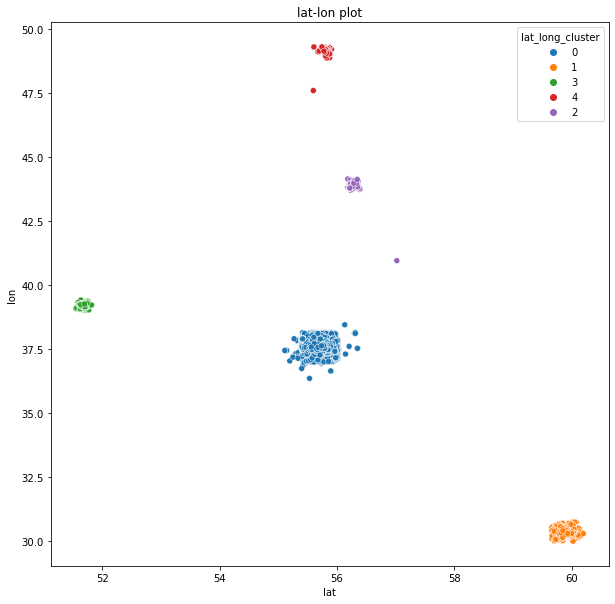

In [14]:
plt.figure(figsize=(10,10))

plt.title('lat-lon plot')
sns.scatterplot(x=data_train['lat'], y= data_train['lon'], hue=data_train['lat_long_cluster'])

plt.show()

In [15]:
data_train.head()

,dist,lat,lon,is_dist,hour,month,total_seconds,total_minutes,f_class_business,f_class_econom,...,t_class_nan,t_class_vip,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,lat_long_cluster
key_0,,,,,,,,,,,,,,,,,,,,,
0,5117.239228,55.669290,37.474336,1,4,1,15000.0,250.0,0,1,...,1,0,0,0,1,0,0,0,0,0
1,3638.726690,55.807461,37.635045,1,13,1,49500.0,825.0,0,1,...,1,0,0,0,0,0,1,0,0,0
2,15143.069693,55.741105,37.615821,1,2,3,7800.0,130.0,0,1,...,1,0,0,0,0,0,0,0,1,0
3,-1.000000,55.625526,37.618543,0,13,2,48000.0,800.0,0,1,...,1,0,0,0,1,0,0,0,0,0
4,4708.142572,55.813167,37.597863,1,19,1,71100.0,1185.0,1,0,...,1,0,0,1,0,0,0,0,0,0


In [24]:
data_train['lat_long_cluster'].fillna(10, inplace=True)

# Data

In [413]:
data_train['lat_long_cluster'].fillna(10, inplace=True)

In [89]:
data_train['add'] = np.log((np.abs(data_train['dist'])+1)/10000).fillna(0)

(array([1.25607e+05, 1.91000e+02, 7.25000e+02, 5.96200e+03, 1.53365e+05,
        7.51136e+05, 1.49091e+05, 6.45000e+02, 5.08000e+02, 2.31000e+02]),
 array([-9.21034037, -7.56581949, -5.92129861, -4.27677773, -2.63225685,
        -0.98773597,  0.65678492,  2.3013058 ,  3.94582668,  5.59034756,
         7.23486844]),
 <BarContainer object of 10 artists>)

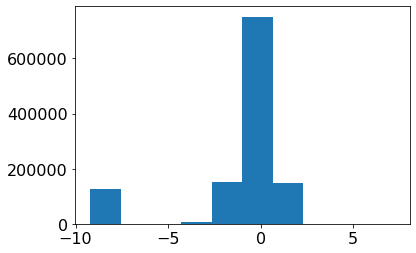

In [94]:
plt.hist(np.log((np.abs(data_train['dist'])+1)/10000).fillna(0))

(array([1.25607e+05, 1.91000e+02, 7.25000e+02, 5.96200e+03, 1.53365e+05,
        7.51136e+05, 1.49091e+05, 6.45000e+02, 5.08000e+02, 2.31000e+02]),
 array([ 0.        ,  1.64452088,  3.28904176,  4.93356264,  6.57808353,
         8.22260441,  9.86712529, 11.51164617, 13.15616705, 14.80068793,
        16.44520881]),
 <BarContainer object of 10 artists>)

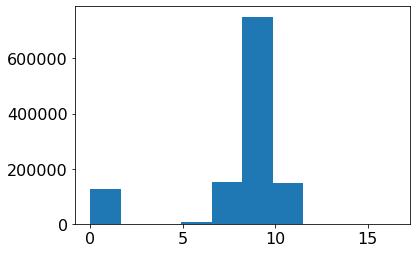

In [95]:
plt.hist(np.log((np.abs(data_train['dist'])+1)).fillna(0))

In [90]:
data_train['add'].min()

-9.210340371976182

In [71]:
def center(data_train):
    data_train['lat2'] = 0
    data_train['lon2'] = 0
    for i in ['0', '1', '2', '3', '4']:
        lat = data_train[data_train['lat_long_cluster']==i]['lat'].mean()
        lon = data_train[data_train['lat_long_cluster']==i]['lon'].mean()
        data_train['lat2'] = data_train['lat2'] + (data_train['lat_long_cluster']==i).astype(int)*lat
        data_train['lon2'] = data_train['lon2'] + (data_train['lat_long_cluster']==i).astype(int)*lon
    data_train['lat2'] = data_train['lat'] - data_train['lat2']
    data_train['lon2'] = data_train['lon'] - data_train['lon2']
    data_train['l'] = np.abs(data_train['lat2']) + np.abs(data_train['lon2'])
    data_train['r'] = np.sqrt(np.power(data_train['lat2'],2) + np.power(data_train['lon2'],2))
    data_train[np.abs(data_train['lat2'])>1]=0
    data_train[np.abs(data_train['lon2'])>1]=0
    return data_train

In [72]:
data_train = center(data_train)

In [73]:
data_train['lon2'].min()

-0.9435700730615579

In [91]:
cancelled = data_train[train_y['target']==1]

In [61]:
cancelled.head()

,dist,lat,lon,is_dist,hour,month,total_seconds,total_minutes,f_class_business,f_class_econom,...,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,lat_long_cluster,lat2,lon2,r,add
key_0,,,,,,,,,,,,,,,,,,,,,
2,15143.069693,55.741105,37.615821,1,2,3,7800.0,130.0,0,1,...,0,0,0,0,1,0,-0.006698,0.027868,0.028662,9.625364
3,-1.000000,55.625526,37.618543,0,13,2,48000.0,800.0,0,1,...,1,0,0,0,0,0,-0.122277,0.030590,0.126045,0.693147
5,9378.037951,55.759841,37.622693,1,23,1,84000.0,1400.0,0,1,...,0,0,1,0,0,0,0.012038,0.034740,0.036767,9.146232
20,13371.221416,60.035567,30.394183,1,1,1,6900.0,115.0,0,1,...,1,0,0,0,0,1,0.106317,0.066227,0.125257,9.500935
24,6172.936928,59.973478,30.350166,1,10,2,38100.0,635.0,0,1,...,0,0,0,0,0,1,0.044228,0.022210,0.049491,8.728092


<ipython-input-47-e32056cf0e9c>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(week, rotation = 45)


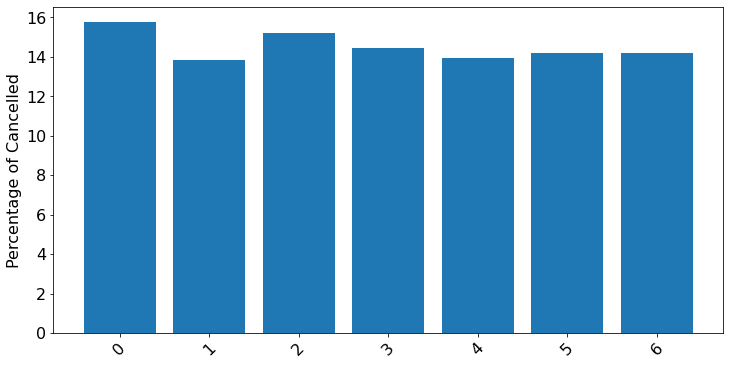

In [47]:
font = {'size'   : 16}
plt.rc('font', **font)
days_cancelled = []
days_total = []
for i in ['day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6']:
    days_cancelled.append(cancelled[i].sum())
    days_total.append(data_train[i].sum())
days_frac = np.divide(days_cancelled, days_total)
week = ['0', '1', '2', '3', '4', '5', '6']

fig, ax = plt.subplots(figsize = (12,6))
ax.bar(week,days_frac*100, align='center')
ax.set_ylabel('Percentage of Cancelled')
ax.set_xticklabels(week, rotation = 45)

plt.show()

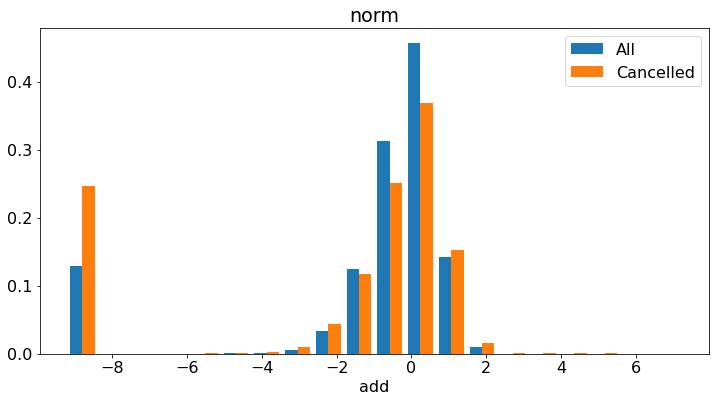

In [93]:
fig, ax = plt.subplots(figsize = (12,6))

ax.hist([data_train['add'], cancelled['add']], density=True, bins=20, label=['All', 'Cancelled'])


ax.set_xlabel('add')
ax.set_title('norm')

plt.legend()
plt.show()

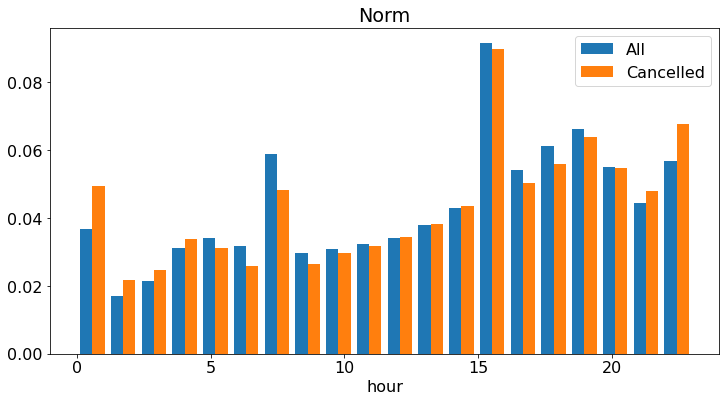

In [49]:
fig, ax = plt.subplots(figsize = (12,6))

ax.hist([data_train['hour'], cancelled['hour']], density=True, bins=20, label=['All', 'Cancelled'])

ax.set_xlabel('hour')
ax.set_title('Norm')

plt.legend()
plt.show()

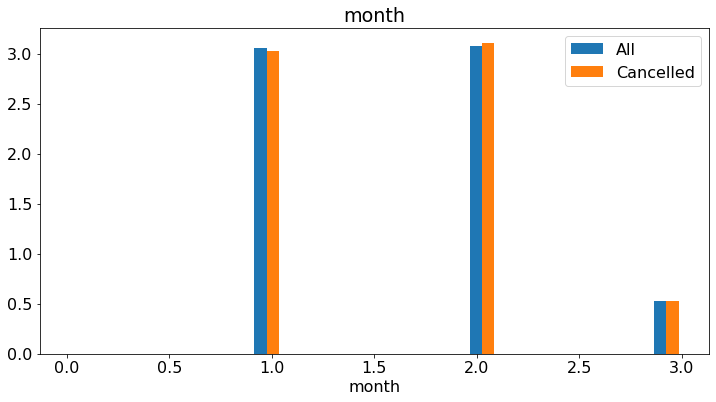

In [105]:
fig, ax = plt.subplots(figsize = (12,6))

ax.hist([data_train['month'], cancelled['month']], density=True, bins=20, label=['All', 'Cancelled'])

ax.set_xlabel('month')
ax.set_title('month')

plt.legend()
plt.show()

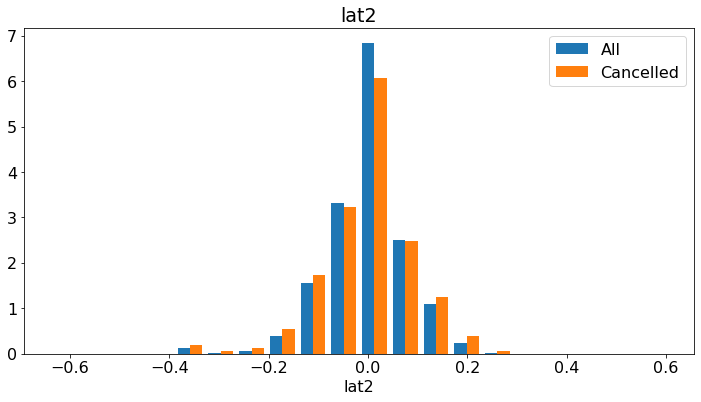

In [75]:
fig, ax = plt.subplots(figsize = (12,6))

ax.hist([data_train['lat2'], cancelled['lat2']], density=True, bins=20, label=['All', 'Cancelled'])

ax.set_xlabel('lat2')
ax.set_title('lat2')

plt.legend()
plt.show()

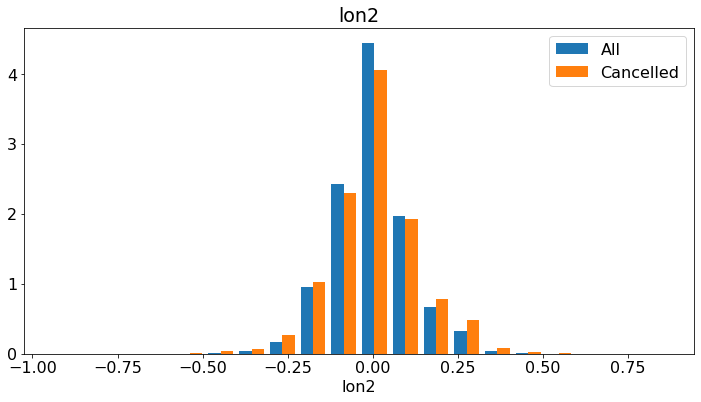

In [76]:
fig, ax = plt.subplots(figsize = (12,6))

ax.hist([data_train['lon2'], cancelled['lon2']], density=True, bins=20, label=['All', 'Cancelled'])

ax.set_xlabel('lon2')
ax.set_title('lon2')

plt.legend()
plt.show()

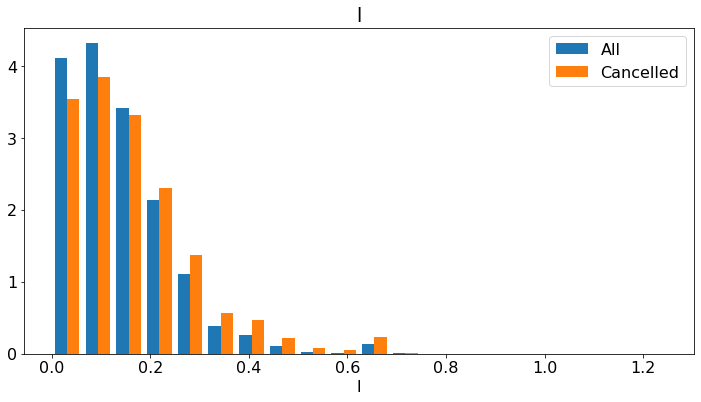

In [77]:
fig, ax = plt.subplots(figsize = (12,6))

ax.hist([data_train['l'], cancelled['l']], density=True, bins=20, label=['All', 'Cancelled'])

ax.set_xlabel('l')
ax.set_title('l')

plt.legend()
plt.show()

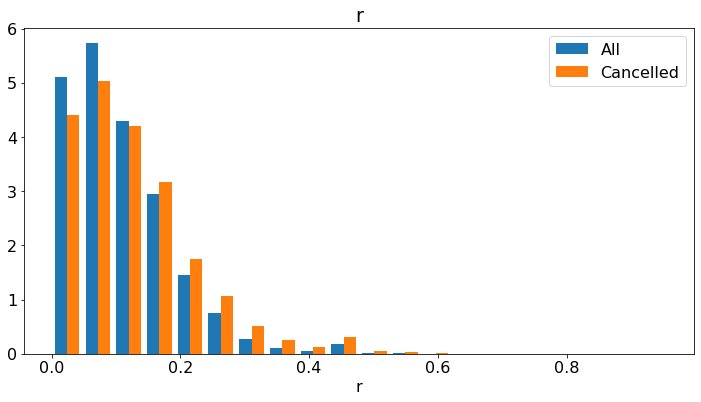

In [78]:
fig, ax = plt.subplots(figsize = (12,6))

ax.hist([data_train['r'], cancelled['r']], density=True, bins=20, label=['All', 'Cancelled'])

ax.set_xlabel('r')
ax.set_title('r')

plt.legend()
plt.show()

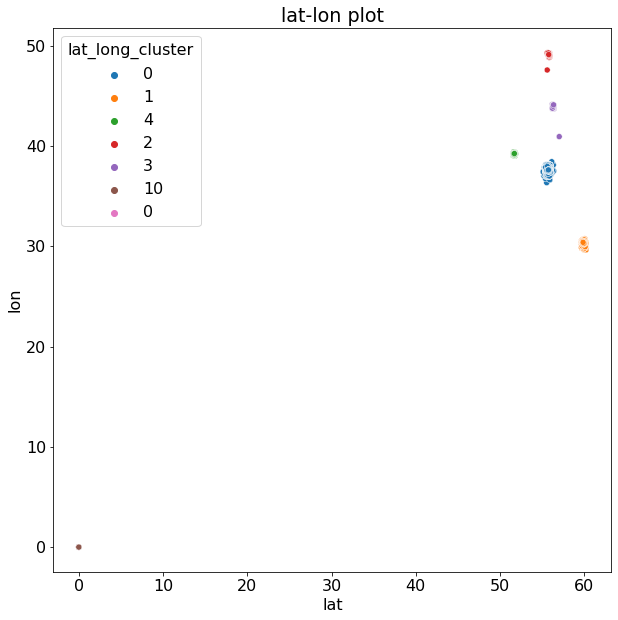

In [46]:
plt.figure(figsize=(10,10))

plt.title('lat-lon plot')
sns.scatterplot(x=data_train['lat'], y= data_train['lon'], hue=data_train['lat_long_cluster'])

plt.show()

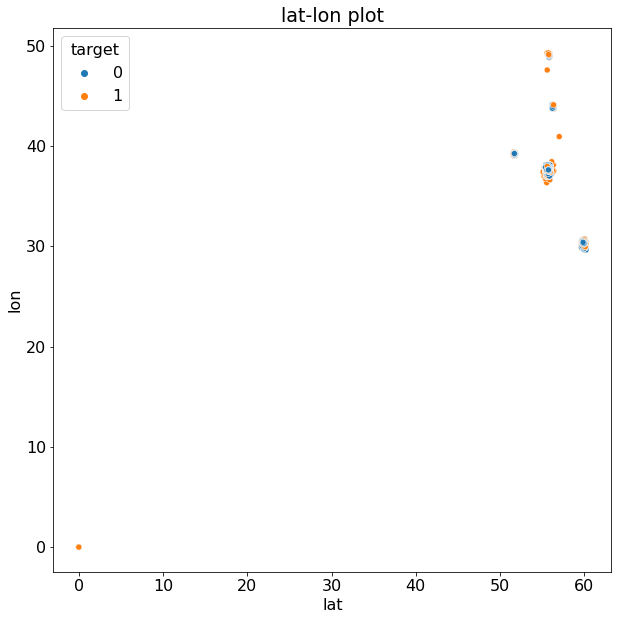

In [51]:
plt.figure(figsize=(10,10))

plt.title('lat-lon plot')
sns.scatterplot(x=data_train['lat'], y= data_train['lon'], hue=train_y['target'])

plt.show()

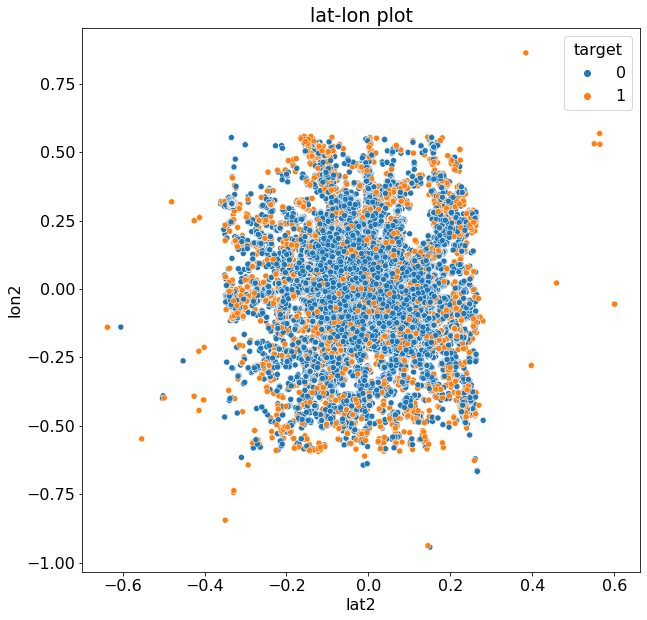

In [79]:
plt.figure(figsize=(10,10))

plt.title('lat-lon plot')
sns.scatterplot(x=data_train['lat2'], y= data_train['lon2'], hue=train_y['target'])

plt.show()

In [421]:
data_train[data_train['lat2']>1]

,dist,lat,lon,is_dist,hour,total_seconds,total_minutes,f_class_business,f_class_econom,f_class_nan,...,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,lat_long_cluster,lat2,lon2,add,r
key_0,,,,,,,,,,,,,,,,,,,,,
11376,33166.392572,60.101176,29.978479,1,23,83700.0,1395.0,0,1,0,...,0,0,0,0,0,0,60.101176,29.978479,10.409323,90.079655
12221,344654.671916,60.092985,29.961716,1,17,61612.0,1026.0,0,1,0,...,0,1,0,0,0,0,60.092985,29.961716,12.750301,90.054701
17034,26551.612248,60.049354,29.965273,1,11,42600.0,710.0,0,1,0,...,0,0,0,1,0,0,60.049354,29.965273,10.186883,90.014627
20337,33123.489372,59.917231,29.767402,1,15,54000.0,900.0,0,1,0,...,0,0,0,1,0,0,59.917231,29.767402,10.408028,89.684633
32178,19722.918696,59.701223,29.840351,1,7,28312.0,471.0,0,1,0,...,1,0,0,0,0,0,59.701223,29.840351,9.889587,89.541574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1154027,17420.448172,60.098270,29.971822,1,11,40080.0,668.0,0,1,0,...,0,0,0,0,1,0,60.098270,29.971822,9.765457,90.070092
1154528,26623.453658,59.869237,29.916881,1,7,25200.0,420.0,0,1,0,...,0,0,0,1,0,0,59.869237,29.916881,10.189585,89.786118
1165154,29859.459034,59.876088,29.918939,1,14,52800.0,880.0,0,1,0,...,0,0,0,0,0,0,59.876088,29.918939,10.304290,89.795027


# Model

In [256]:
data_train['lat_long_cluster'].unique()[5]

nan

In [96]:
data_train.columns

Index(['dist', 'lat', 'lon', 'is_dist', 'hour', 'month', 'total_seconds',
       'total_minutes', 'f_class_business', 'f_class_econom', 'f_class_nan',
       'f_class_vip', 's_class_business', 's_class_econom', 's_class_nan',
       's_class_vip', 't_class_business', 't_class_econom', 't_class_nan',
       't_class_vip', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2',
       'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6',
       'lat_long_cluster', 'lat2', 'lon2', 'r', 'add', 'l'],
      dtype='object')

In [97]:
params = {
    'iterations': 2000,
    'loss_function': "Logloss",
    'thread_count': 8,
    'depth': 7, 
    'learning_rate': 0.1, 
    'random_state': 0,
    'eval_metric': 'AUC',
}

In [115]:
feat = ['dist', 'lat', 'lon', 'is_dist', 'hour', 'total_seconds',
       'total_minutes', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2',
       'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6',
       'lat_long_cluster', 'lat2', 'lon2', 'r', 'l']
train_cols = feat
cat_features = []

In [116]:
X_train, X_test, y_train, y_test = train_test_split(data_train, train_y, test_size=0.2, random_state=42)

In [117]:
train_pool = catboost.Pool(
    X_train.loc[:, train_cols],
    label=y_train.target,
    cat_features=cat_features
)

In [118]:
model = catboost.CatBoost(params)
model.fit(
    train_pool, 
    eval_set=train_pool,
    verbose=100,
)

print(model.learning_rate_)
model.get_feature_importance(train_pool, prettified=True).head(50)

0:	test: 0.6048478	best: 0.6048478 (0)	total: 117ms	remaining: 3m 54s
100:	test: 0.6490741	best: 0.6490741 (100)	total: 8.46s	remaining: 2m 39s
200:	test: 0.6553761	best: 0.6553761 (200)	total: 17.1s	remaining: 2m 32s
300:	test: 0.6605793	best: 0.6605793 (300)	total: 25.7s	remaining: 2m 24s
400:	test: 0.6648803	best: 0.6648803 (400)	total: 34.4s	remaining: 2m 17s
500:	test: 0.6686214	best: 0.6686214 (500)	total: 44.3s	remaining: 2m 12s
600:	test: 0.6721843	best: 0.6721843 (600)	total: 53.5s	remaining: 2m 4s
700:	test: 0.6756194	best: 0.6756194 (700)	total: 1m 2s	remaining: 1m 56s
800:	test: 0.6788670	best: 0.6788670 (800)	total: 1m 11s	remaining: 1m 47s
900:	test: 0.6820312	best: 0.6820312 (900)	total: 1m 21s	remaining: 1m 39s
1000:	test: 0.6848909	best: 0.6848909 (1000)	total: 1m 30s	remaining: 1m 30s
1100:	test: 0.6879030	best: 0.6879030 (1100)	total: 1m 39s	remaining: 1m 21s
1200:	test: 0.6907001	best: 0.6907001 (1200)	total: 1m 49s	remaining: 1m 12s
1300:	test: 0.6935974	best: 0.69

,Feature Id,Importances
0,dist,19.789683
1,l,10.693733
2,r,10.409447
3,lat2,8.812718
4,lon2,7.976296
5,lat,6.946866
6,total_seconds,6.373763
7,lon,5.817580
8,total_minutes,5.757306
9,hour,1.605964


In [119]:
test_pool = catboost.Pool(
    X_test.loc[:, train_cols],
    cat_features=cat_features
)

In [120]:
print(roc(y_test, model.predict(test_pool, prediction_type='Probability')[:, 1]))

0.6622499347990292


In [104]:
print(roc(y_test, model.predict(test_pool, prediction_type='Probability')[:, 1]))

0.6621365926039882


In [46]:
X_train, X_test, y_train, y_test = train_test_split(df_train[features], train_y, test_size=0.2, random_state=42)

In [48]:
features1 = ['dist', 'lat', 'lon', 'lat_long_cluster', 'f1', 'f2', 'f3', 's1', 's2', 's3', 't1', 't2', 't3', 'month', 'day', 'hours', 'min']

In [49]:
model1 = LGBMClassifier(learning_rate=0.2, max_depth=8, n_estimators=500,  random_state=0)
model1.fit(X_train[features1], y_train)

C:\Users\di46yoc\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LGBMClassifier(learning_rate=0.2, max_depth=8, n_estimators=500, random_state=0)

In [50]:
print(roc(y_test, model1.predict(X_test[features1])))
print(roc(y_test, model1.predict_proba(X_test[features1])[:, 1]))

0.5198296378877513
0.6669728962783683


In [81]:
model1.feature_importances_

array([2809, 2804, 2843,   80,  138,  119,   98,   41,  272,   87,   35,
         23,   87,  502, 1873, 1828, 1361])

In [90]:
sub = pd.read_csv('1_data/sample_submission.csv')

In [91]:
sub['target']=model.predict(test_pool, prediction_type='Probability')[:, 1]

In [92]:
sub.to_csv('submission.csv', index=False)